In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [47]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy

def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended


def is_mjj(month):
    return (month>=5) & (month<=7)

def is_mam(month):
    return (month>=3) & (month<=5)

def is_jja(month):
    return (month>=6) & (month<=8)
def is_jas(month):
    return (month>=7) & (month<=9)

def is_nd(month):
    return (month==11) | (month==12)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'


dir_tos_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/'
dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/'
#dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/HadI-SST/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'

period_str = 1985
period_end = 2004
%matplotlib inline
dir_ccmp = '/media/aprigent/Arthur_disk/TAV_OMIP/'

dir_jra55 = '/media/aprigent/Arthur_disk/Data/MOM_JRA55do/'

dir_core2 = '/media/aprigent/Arthur_disk/Data/CORE2/'

/tmp/ipykernel_4038/469596275.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Winds CCMP v2

u-wind

In [3]:
uwind_ccmp = xr.open_dataset(dir_ccmp+'ccmp_uwind_r360x180.nc')

uwind_ccmp = uwind_ccmp.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))

uwind_ccmp = xr.concat([uwind_ccmp.uwnd[:,:,180:],uwind_ccmp.uwnd[:,:,:180]],dim = 'lon') 
uwind_ccmp.coords['lon'] = (uwind_ccmp.coords['lon'] + 180)%360 - 180
uwind_ccmp_arr = np.array(uwind_ccmp)
uwind_ccmp_dtd = np.ones((uwind_ccmp.shape))*np.nan
for i in range(uwind_ccmp_dtd.shape[1]):
    for j in range(uwind_ccmp_dtd.shape[2]):
        uwind_ccmp_dtd[:,i,j] = nandetrend(uwind_ccmp_arr[:,i,j])
        
uas_ccmp_atl_dtd  = xr.Dataset({'uas_dtd': (['time','lat','lon'],uwind_ccmp_dtd)}
                       ,coords={'time':np.array(uwind_ccmp.time),
                                'lon':np.array(uwind_ccmp.lon),
                                'lat':np.array(uwind_ccmp.lat)
                                })

uas_ccmp_atl_dtd = Atools.data_sub(uas_ccmp_atl_dtd,-40,20,-3,3)

In [4]:
uas_ccmp_eq_dtd_mam = uas_ccmp_atl_dtd.sel(
    time=is_mam(uas_ccmp_atl_dtd['time.month'])).mean(dim='time').mean(dim='lat')

uas_ccmp_eq_dtd_jas = uas_ccmp_atl_dtd.sel(
    time=is_jas(uas_ccmp_atl_dtd['time.month'])).mean(dim='time').mean(dim='lat')


In [5]:
uas_ccmp_eq_dtd_mam_40w_10e = uas_ccmp_eq_dtd_mam.where((uas_ccmp_eq_dtd_mam.lon>-40)&
                                                        (uas_ccmp_eq_dtd_mam.lon<10),drop=True)

uas_ccmp_eq_dtd_jas_40w_10e = uas_ccmp_eq_dtd_jas.where((uas_ccmp_eq_dtd_jas.lon>-40)&
                                                        (uas_ccmp_eq_dtd_jas.lon<10),drop=True)

In [6]:
print('zonal winds JAS =', np.round(uas_ccmp_eq_dtd_jas_40w_10e.uas_dtd.mean(dim='lon').values,2),'m/s')
print('zonal winds MAM =', np.round(uas_ccmp_eq_dtd_mam_40w_10e.uas_dtd.mean(dim='lon').values,2),'m/s')

zonal winds JAS = -2.24 m/s
zonal winds MAM = -1.91 m/s


# ORA-S5

In [7]:
## sst ##

sst_oras5_tmp = xr.open_dataset(dir_obs_sst+'ORA-S5/sosstsst_merged_r360x180_oras5_1984_2005.nc')
sst_oras5_tmp = sst_oras5_tmp.sosstsst[:] # K to degC
sst_oras5 = sst_oras5_tmp.sel(time_counter=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_oras5_arr = np.array(sst_oras5)
sst_oras5_atl_dtd = np.ones((sst_oras5_arr.shape))*np.nan
for i in range(sst_oras5_atl_dtd.shape[1]):
    for j in range(sst_oras5_atl_dtd.shape[2]):
        sst_oras5_atl_dtd[:,i,j] = nandetrend(sst_oras5_arr[:,i,j])
        
        
sst_oras5_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_oras5_atl_dtd)}
                       ,coords={'time':np.array(sst_oras5.time_counter),
                                'lon':np.array(sst_oras5.lon),
                                'lat':np.array(sst_oras5.lat)
                                })

In [8]:
sst_oras5_atl_dtd_xarray_atl = Atools.data_sub(sst_oras5_atl_dtd_xarray,-40,20,-30,10)

sst_oras5_atl_dtd_xarray_atl_mjj = sst_oras5_atl_dtd_xarray_atl.sel(
    time=is_mjj(sst_oras5_atl_dtd_xarray_atl['time.month']))

sst_oras5_mjj_mean = sst_oras5_atl_dtd_xarray_atl_mjj.mean(dim='time')


In [9]:
sst_oras5_atl_dtd_xarray_atl3 = Atools.data_sub(sst_oras5_atl_dtd_xarray,-20,0,-3,3)
sst_oras5_atl_dtd_xarray_atl3_mean = sst_oras5_atl_dtd_xarray_atl3.weighted(
        np.cos(np.deg2rad(sst_oras5_atl_dtd_xarray_atl3.lat))).mean(('lon','lat'))

In [10]:
seasonal_cycle_sst_oras5_atl3_mean = sst_oras5_atl_dtd_xarray_atl3_mean.groupby('time.month').mean()

In [11]:
thetao_eq_oras5 = xr.open_dataset(path_data_out+'temp_oras5_eq_1985_2004.nc')


thetao_eq_oras5_mam = thetao_eq_oras5.sel(
    time=is_mam(thetao_eq_oras5['time.month']))

thetao_eq_oras5_jas = thetao_eq_oras5.sel(
    time=is_jas(thetao_eq_oras5['time.month']))

In [12]:
thetao_eq_oras5_mam_mean = thetao_eq_oras5_mam.mean(dim='time') 
thetao_eq_oras5_jas_mean = thetao_eq_oras5_jas.mean(dim='time') 


In [13]:
thetao_eq_oras5_mam_mean_25m = thetao_eq_oras5_mam_mean.where(thetao_eq_oras5_mam_mean.depth<25,drop=True)
thetao_eq_oras5_mam_mean_25m_atl3 = thetao_eq_oras5_mam_mean_25m.where(
    (thetao_eq_oras5_mam_mean_25m.lon>-20)&
    (thetao_eq_oras5_mam_mean_25m.lon<0),drop=True)


thetao_eq_oras5_jas_mean_25m = thetao_eq_oras5_jas_mean.where(thetao_eq_oras5_jas_mean.depth<25,drop=True)
thetao_eq_oras5_jas_mean_25m_atl3 = thetao_eq_oras5_jas_mean_25m.where(
    (thetao_eq_oras5_jas_mean_25m.lon>-20)&
    (thetao_eq_oras5_jas_mean_25m.lon<0),drop=True)

In [14]:
print('top 25 m temperature MAM = ', np.round(thetao_eq_oras5_mam_mean_25m_atl3.temp.mean().values,2),'degC')
print('top 25 m temperature JAS = ', np.round(thetao_eq_oras5_jas_mean_25m_atl3.temp.mean().values,2),'degC')

top 25 m temperature MAM =  28.44 degC
top 25 m temperature JAS =  24.67 degC


## dtdz

In [15]:
dtdz_eq_oras5 = xr.open_dataset(path_data_out+'dtdz_oras5_eq_1985_2004_newtest.nc')
dtdz_eq_oras5_mam = dtdz_eq_oras5.dtdz_max.sel(time=is_mam(dtdz_eq_oras5.dtdz_max['time.month'])).mean(dim='time')
dtdz_eq_oras5_jas = dtdz_eq_oras5.dtdz_max.sel(time=is_jas(dtdz_eq_oras5.dtdz_max['time.month'])).mean(dim='time')


In [16]:
dtdz_eq_oras5_mam_atl4 = dtdz_eq_oras5_mam.where((dtdz_eq_oras5_mam.lon>-40)&
                                                 (dtdz_eq_oras5_mam.lon<-20),drop=True).mean(dim='lon')

dtdz_eq_oras5_mam_atl3 = dtdz_eq_oras5_mam.where((dtdz_eq_oras5_mam.lon>-20)&
                                                 (dtdz_eq_oras5_mam.lon<0),drop=True).mean(dim='lon')


dtdz_eq_oras5_jas_atl4 = dtdz_eq_oras5_jas.where((dtdz_eq_oras5_jas.lon>-40)&
                                                 (dtdz_eq_oras5_jas.lon<-20),drop=True).mean(dim='lon')

dtdz_eq_oras5_jas_atl3 = dtdz_eq_oras5_jas.where((dtdz_eq_oras5_jas.lon>-20)&
                                                 (dtdz_eq_oras5_jas.lon<0),drop=True).mean(dim='lon')

In [17]:
print('MAM tilt = ',np.round(dtdz_eq_oras5_mam_atl4.values - dtdz_eq_oras5_mam_atl3.values,2),'m')
print('JAS tilt = ',np.round(dtdz_eq_oras5_jas_atl4.values - dtdz_eq_oras5_jas_atl3.values,2),'m')

MAM tilt =  23.3 m
JAS tilt =  44.45 m


## mld

In [18]:
mld_eq_oras5 = xr.open_dataset(path_data_out+'mld_oras5_1985_2004.nc')
mld_eq_oras5_mam = mld_eq_oras5.mld.sel(time=is_mam(mld_eq_oras5.mld['time.month'])).mean(dim='lat').mean(dim='time')
mld_eq_oras5_jas = mld_eq_oras5.mld.sel(time=is_jas(mld_eq_oras5.mld['time.month'])).mean(dim='lat').mean(dim='time')


In [19]:
mld_eq_oras5_mam_atl3 = mld_eq_oras5_mam.where((mld_eq_oras5_mam.lon>-20)&(mld_eq_oras5_mam.lon<0),drop=True).mean()
mld_eq_oras5_jas_atl3 = mld_eq_oras5_jas.where((mld_eq_oras5_jas.lon>-20)&(mld_eq_oras5_jas.lon<0),drop=True).mean()


print('MAM MLD = ', np.round(mld_eq_oras5_mam_atl3.values,2),'m')

print('JAS MLD = ', np.round(mld_eq_oras5_jas_atl3.values,2),'m')

MAM MLD =  18.87 m
JAS MLD =  26.26 m


# OMIPs

In [20]:
## dtdz ##
dtdz_eq_omip1 = xr.open_dataset(path_data_out+'dtdz_eq_omip1_1985_2004_newtest_new.nc')
dtdz_eq_omip2 = xr.open_dataset(path_data_out+'dtdz_eq_omip2_1985_2004_newtest.nc')


In [21]:
dtdz_eq_omip1_mam = dtdz_eq_omip1.dtdz_max.sel(
    time=is_mam(dtdz_eq_omip1.dtdz_max['time.month'])).mean(dim='time')
dtdz_eq_omip1_jas = dtdz_eq_omip1.dtdz_max.sel(
    time=is_jas(dtdz_eq_omip1.dtdz_max['time.month'])).mean(dim='time')



dtdz_eq_omip2_mam = dtdz_eq_omip2.dtdz_max.sel(
    time=is_mam(dtdz_eq_omip2.dtdz_max['time.month'])).mean(dim='time')
dtdz_eq_omip2_jas = dtdz_eq_omip2.dtdz_max.sel(
    time=is_jas(dtdz_eq_omip2.dtdz_max['time.month'])).mean(dim='time')

In [22]:
dtdz_eq_omip1_mam_atl3 = dtdz_eq_omip1_mam.where((dtdz_eq_omip1_mam.lon>-20)&(dtdz_eq_omip1_mam.lon<0),drop=True).mean(dim='lon')
dtdz_eq_omip1_mam_atl4 = dtdz_eq_omip1_mam.where((dtdz_eq_omip1_mam.lon>-40)&(dtdz_eq_omip1_mam.lon<-20),drop=True).mean(dim='lon')


dtdz_eq_omip1_jas_atl3 = dtdz_eq_omip1_jas.where((dtdz_eq_omip1_jas.lon>-20)&(dtdz_eq_omip1_jas.lon<0),drop=True).mean(dim='lon')
dtdz_eq_omip1_jas_atl4 = dtdz_eq_omip1_jas.where((dtdz_eq_omip1_jas.lon>-40)&(dtdz_eq_omip1_jas.lon<-20),drop=True).mean(dim='lon')

In [23]:
dtdz_eq_omip2_mam_atl3 = dtdz_eq_omip2_mam.where((dtdz_eq_omip2_mam.lon>-20)&(dtdz_eq_omip2_mam.lon<0),drop=True).mean(dim='lon')
dtdz_eq_omip2_mam_atl4 = dtdz_eq_omip2_mam.where((dtdz_eq_omip2_mam.lon>-40)&(dtdz_eq_omip2_mam.lon<-20),drop=True).mean(dim='lon')


dtdz_eq_omip2_jas_atl3 = dtdz_eq_omip2_jas.where((dtdz_eq_omip2_jas.lon>-20)&(dtdz_eq_omip2_jas.lon<0),drop=True).mean(dim='lon')
dtdz_eq_omip2_jas_atl4 = dtdz_eq_omip2_jas.where((dtdz_eq_omip2_jas.lon>-40)&(dtdz_eq_omip2_jas.lon<-20),drop=True).mean(dim='lon')

In [24]:
tilt_omip1_mam = dtdz_eq_omip1_mam_atl4 - dtdz_eq_omip1_mam_atl3
tilt_omip1_jas = dtdz_eq_omip1_jas_atl4 - dtdz_eq_omip1_jas_atl3

tilt_omip2_mam = dtdz_eq_omip2_mam_atl4 - dtdz_eq_omip2_mam_atl3
tilt_omip2_jas = dtdz_eq_omip2_jas_atl4 - dtdz_eq_omip2_jas_atl3


print('tilt thermocline mam omip1 =',np.round(tilt_omip1_mam.mean(dim='model').values,2),'+/-',
      np.round(tilt_omip1_mam.std(dim='model').values,2),'m')


print('tilt thermocline jas omip1 =',np.round(tilt_omip1_jas.mean(dim='model').values,2),'+/-',
      np.round(tilt_omip1_jas.std(dim='model').values,2),'m')

print('  ')

print('tilt thermocline mam omip2 =',np.round(tilt_omip2_mam.mean(dim='model').values,2),'+/-',
      np.round(tilt_omip1_mam.std(dim='model').values,2),'m')


print('tilt thermocline jas omip2 =',np.round(tilt_omip2_jas.mean(dim='model').values,2),'+/-',
      np.round(tilt_omip2_jas.std(dim='model').values,2),'m')

tilt thermocline mam omip1 = 30.39 +/- 3.79 m
tilt thermocline jas omip1 = 46.64 +/- 3.36 m
  
tilt thermocline mam omip2 = 35.04 +/- 3.79 m
tilt thermocline jas omip2 = 44.03 +/- 3.59 m


# temp

In [25]:
## temp ##
thetao_eq_omip1 = xr.open_dataset(path_data_out+'temp_omip1_eq_1985_2004_new.nc')
thetao_eq_omip2 = xr.open_dataset(path_data_out+'temp_omip2_eq_1985_2004.nc')


In [26]:
thetao_eq_omip1_mam = thetao_eq_omip1.temp.sel(
    time=is_mam(thetao_eq_omip1.temp['time.month'])).mean(dim='time')

thetao_eq_omip1_jas = thetao_eq_omip1.temp.sel(
    time=is_jas(thetao_eq_omip1.temp['time.month'])).mean(dim='time')


thetao_eq_omip2_mam = thetao_eq_omip2.temp.sel(
    time=is_mam(thetao_eq_omip2.temp['time.month'])).mean(dim='time')

thetao_eq_omip2_jas = thetao_eq_omip2.temp.sel(
    time=is_jas(thetao_eq_omip2.temp['time.month'])).mean(dim='time')

In [27]:
thetao_eq_omip1_mam_25m = thetao_eq_omip1_mam.where(thetao_eq_omip1_mam.depth<25,drop=True)
thetao_eq_omip1_jas_25m = thetao_eq_omip1_jas.where(thetao_eq_omip1_jas.depth<25,drop=True)


thetao_eq_omip2_mam_25m = thetao_eq_omip2_mam.where(thetao_eq_omip2_mam.depth<25,drop=True)
thetao_eq_omip2_jas_25m = thetao_eq_omip2_jas.where(thetao_eq_omip2_jas.depth<25,drop=True)

In [28]:
thetao_eq_omip1_mam_25m_atl3 = thetao_eq_omip1_mam_25m.where((thetao_eq_omip1_mam_25m.lon>-20)&
                                                             (thetao_eq_omip1_mam_25m.lon<0),drop=True).mean(dim='depth').mean(dim='lon')

thetao_eq_omip1_jas_25m_atl3 = thetao_eq_omip1_jas_25m.where((thetao_eq_omip1_jas_25m.lon>-20)&
                                                             (thetao_eq_omip1_jas_25m.lon<0),drop=True).mean(dim='depth').mean(dim='lon')


thetao_eq_omip2_mam_25m_atl3 = thetao_eq_omip2_mam_25m.where((thetao_eq_omip2_mam_25m.lon>-20)&
                                                             (thetao_eq_omip2_mam_25m.lon<0),drop=True).mean(dim='depth').mean(dim='lon')

thetao_eq_omip2_jas_25m_atl3 = thetao_eq_omip2_jas_25m.where((thetao_eq_omip2_jas_25m.lon>-20)&
                                                             (thetao_eq_omip2_jas_25m.lon<0),drop=True).mean(dim='depth').mean(dim='lon')


In [29]:
print('temp 25 m MAM omip1 = ', np.round(thetao_eq_omip1_mam_25m_atl3.mean(dim='model').values,2),'+/-',
      np.round(thetao_eq_omip1_mam_25m_atl3.std(dim='model').values,2))


print('temp 25 m JAS omip1 = ', np.round(thetao_eq_omip1_jas_25m_atl3.mean(dim='model').values,2),'+/-',
      np.round(thetao_eq_omip1_jas_25m_atl3.std(dim='model').values,2))


print( '  ')
print('temp 25 m MAM omip2 = ', np.round(thetao_eq_omip2_mam_25m_atl3.mean(dim='model').values,2),'+/-',
      np.round(thetao_eq_omip2_mam_25m_atl3.std(dim='model').values,2))

print('temp 25 m JAS omip2 = ', np.round(thetao_eq_omip2_jas_25m_atl3.mean(dim='model').values,2),'+/-',
      np.round(thetao_eq_omip2_jas_25m_atl3.std(dim='model').values,2))

temp 25 m MAM omip1 =  28.4 +/- 0.05
temp 25 m JAS omip1 =  25.26 +/- 0.11
  
temp 25 m MAM omip2 =  28.44 +/- 0.12
temp 25 m JAS omip2 =  25.28 +/- 0.19


In [30]:
## MLD ##
mld_eq_omip1 = xr.open_dataset(path_data_out+'mld_omip1_eq_1985_2004_cycle5.nc')
mld_eq_omip2 = xr.open_dataset(path_data_out+'mld_omip2_eq_1985_2004.nc')


In [31]:
mld_eq_omip1_mam = mld_eq_omip1.mld.sel(
    time=is_mam(mld_eq_omip1.mld['time.month'])).mean(dim='time')

mld_eq_omip1_jas = mld_eq_omip1.mld.sel(
    time=is_jas(mld_eq_omip1.mld['time.month'])).mean(dim='time')




mld_eq_omip2_mam = mld_eq_omip2.mld.sel(
    time=is_mam(mld_eq_omip2.mld['time.month'])).mean(dim='time')

mld_eq_omip2_jas = mld_eq_omip2.mld.sel(
    time=is_jas(mld_eq_omip2.mld['time.month'])).mean(dim='time')


In [32]:
mld_eq_omip1_mam_atl3 = mld_eq_omip1_mam.where((mld_eq_omip1_mam.lon>-20)&
                                               (mld_eq_omip1_mam.lon<0),drop=True).mean(dim='lon')

mld_eq_omip1_jas_atl3 = mld_eq_omip1_jas.where((mld_eq_omip1_jas.lon>-20)&
                                               (mld_eq_omip1_jas.lon<0),drop=True).mean(dim='lon')


mld_eq_omip2_mam_atl3 = mld_eq_omip2_mam.where((mld_eq_omip2_mam.lon>-20)&
                                               (mld_eq_omip2_mam.lon<0),drop=True).mean(dim='lon')

mld_eq_omip2_jas_atl3 = mld_eq_omip2_jas.where((mld_eq_omip2_jas.lon>-20)&
                                               (mld_eq_omip2_jas.lon<0),drop=True).mean(dim='lon')

In [33]:
print('MLD ATL3 OMIP1 MAM = ',np.round(mld_eq_omip1_mam_atl3.mean(dim='model').values,2),'+/-',
      np.round(mld_eq_omip1_mam_atl3.std(dim='model').values,2),'m')
print('MLD ATL3 OMIP1 JAS = ',np.round(mld_eq_omip1_jas_atl3.mean(dim='model').values,2),'+/-',
      np.round(mld_eq_omip1_jas_atl3.std(dim='model').values,2),'m')


print('MLD ATL3 OMIP2 MAM = ',np.round(mld_eq_omip2_mam_atl3.mean(dim='model').values,2),'+/-',
      np.round(mld_eq_omip2_mam_atl3.std(dim='model').values,2),'m')
print('MLD ATL3 OMIP2 JAS = ',np.round(mld_eq_omip2_jas_atl3.mean(dim='model').values,2),'+/-',
      np.round(mld_eq_omip2_jas_atl3.std(dim='model').values,2),'m')

MLD ATL3 OMIP1 MAM =  16.36 +/- 1.53 m
MLD ATL3 OMIP1 JAS =  23.91 +/- 2.92 m
MLD ATL3 OMIP2 MAM =  13.9 +/- 3.44 m
MLD ATL3 OMIP2 JAS =  26.2 +/- 5.84 m


In [34]:
uwind_CORE2_tmp = xr.open_dataset(dir_core2+'u_10_mod.1948-2007.paddednomads_atl_monmean_r360x180.nc',
                                  use_cftime=True) 

uwind_CORE2_tmp['TIME'] = uwind_CORE2_tmp.indexes['TIME'].to_datetimeindex()

uwind_CORE2_tmp = xr.concat([uwind_CORE2_tmp.U_10_MOD[:,:,180:],
                             uwind_CORE2_tmp.U_10_MOD[:,:,:180]],dim = 'lon') 
uwind_CORE2_tmp.coords['lon'] = (uwind_CORE2_tmp.coords['lon'] + 180)%360 - 180

uwind_CORE2_tmp = Atools.data_sub(uwind_CORE2_tmp,-40,20,-3,3)


uwind_CORE2_tmp = uwind_CORE2_tmp.sel(TIME=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

/tmp/ipykernel_4038/2526213667.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  uwind_CORE2_tmp['TIME'] = uwind_CORE2_tmp.indexes['TIME'].to_datetimeindex()


In [35]:
uas_core2_eq_arr = np.array(uwind_CORE2_tmp)
uas_core2_eq_dtd = np.ones((uwind_CORE2_tmp.shape))*np.nan
for i in range(uas_core2_eq_dtd.shape[1]):
    for j in range(uas_core2_eq_dtd.shape[2]):
        uas_core2_eq_dtd[:,i,j] = nandetrend(uas_core2_eq_arr[:,i,j])

        
uas_core2_eq_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uas_core2_eq_dtd), 
    }, 
    coords={'time': np.array(uwind_CORE2_tmp.TIME), 
    'lat': np.array(uwind_CORE2_tmp.lat), 
    'lon': np.array(uwind_CORE2_tmp.lon)} ) 





In [36]:
uas_core2_eq_dataset_monthly_mean = uas_core2_eq_dataset.mean(dim='lat')



In [37]:

uas_core2_eq_mam = uas_core2_eq_dataset_monthly_mean.sel(
    time=is_mam(uas_core2_eq_dataset_monthly_mean['time.month'])).mean(dim='time')

uas_core2_eq_jas = uas_core2_eq_dataset_monthly_mean.sel(
    time=is_jas(uas_core2_eq_dataset_monthly_mean['time.month'])).mean(dim='time')

In [38]:
uas_core2_eq_mam_40w_10e = uas_core2_eq_mam.uas_dtd.where((uas_core2_eq_mam.lon>-40)&
                                                  (uas_core2_eq_mam.lon<10),drop=True).mean(dim='lon')

uas_core2_eq_jas_40w_10e = uas_core2_eq_jas.uas_dtd.where((uas_core2_eq_jas.lon>-40)&
                                                  (uas_core2_eq_jas.lon<10),drop=True).mean(dim='lon')

In [39]:
print('uwind equatorial Atlantic core2 MAM =',np.round(uas_core2_eq_mam_40w_10e.values,2),'m/s')
print('uwind equatorial Atlantic core2 JAS =',np.round(uas_core2_eq_jas_40w_10e.values,2),'m/s')

uwind equatorial Atlantic core2 MAM = -1.89 m/s
uwind equatorial Atlantic core2 JAS = -2.76 m/s


In [40]:
uwind_JRA55_tmp = xr.open_dataset(dir_jra55+'JRA_uas.1958_2022_atl_monmean_r360x180.nc') 
uwind_JRA55_tmp = xr.concat([uwind_JRA55_tmp.uas[:,:,180:],uwind_JRA55_tmp.uas[:,:,:180]],dim = 'lon') 
uwind_JRA55_tmp.coords['lon'] = (uwind_JRA55_tmp.coords['lon'] + 180)%360 - 180

uwind_JRA55_tmp = Atools.data_sub(uwind_JRA55_tmp,-40,20,-3,3)


uwind_JRA55 = uwind_JRA55_tmp.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
uwind_JRA55_arr = np.array(uwind_JRA55)
uwind_JRA55_atl_dtd = np.ones((uwind_JRA55_arr.shape))*np.nan
for i in range(uwind_JRA55_atl_dtd.shape[1]):
    for j in range(uwind_JRA55_atl_dtd.shape[2]):
        uwind_JRA55_atl_dtd[:,i,j] = nandetrend(uwind_JRA55_arr[:,i,j])
        
        
uwind_JRA55_atl_dtd_xarray  = xr.Dataset({'uas_dtd': (['time','lat','lon'],uwind_JRA55_atl_dtd)}
                       ,coords={'time':np.array(uwind_JRA55.time),
                                'lon':np.array(uwind_JRA55.lon),
                                'lat':np.array(uwind_JRA55.lat)
                                })


uas_jra55_eq_dataset_monthly_mean = uwind_JRA55_atl_dtd_xarray.mean(dim='lat')


In [41]:

uas_jra55_eq_mam = uas_jra55_eq_dataset_monthly_mean.sel(
    time=is_mam(uas_jra55_eq_dataset_monthly_mean['time.month'])).mean(dim='time')

uas_jra55_eq_jas = uas_jra55_eq_dataset_monthly_mean.sel(
    time=is_jas(uas_jra55_eq_dataset_monthly_mean['time.month'])).mean(dim='time')

In [42]:
uas_jra55_eq_mam_40w_10e = uas_jra55_eq_mam.uas_dtd.where((uas_jra55_eq_mam.lon>-40)&
                                                  (uas_jra55_eq_mam.lon<10),drop=True).mean(dim='lon')

uas_jra55_eq_jas_40w_10e = uas_jra55_eq_jas.uas_dtd.where((uas_jra55_eq_jas.lon>-40)&
                                                  (uas_jra55_eq_jas.lon<10),drop=True).mean(dim='lon')

In [43]:
print('uwind equatorial Atlantic jra55 MAM =',np.round(uas_jra55_eq_mam_40w_10e.values,2),'m/s')
print('uwind equatorial Atlantic jra55 JAS =',np.round(uas_jra55_eq_jas_40w_10e.values,2),'m/s')

uwind equatorial Atlantic jra55 MAM = -1.99 m/s
uwind equatorial Atlantic jra55 JAS = -2.27 m/s


# vertical velocities

In [44]:
wo_omip1 = xr.open_dataset(path_data_out+'wo_omip1_eq_1985_2004_new.nc')
wo_omip2 = xr.open_dataset(path_data_out+'wo_omip2_eq_1985_2004.nc')

In [45]:
wo_omip1_atl3 = wo_omip1.where((wo_omip1.lon>-20)&
                               (wo_omip1.lon<0),drop=True).mean(dim='lon')

wo_omip2_atl3 = wo_omip2.where((wo_omip2.lon>-20)&
                               (wo_omip2.lon<0),drop=True).mean(dim='lon')

In [46]:
wo_omip1_atl3_mam = wo_omip1_atl3.sel(time=is_mam(
    wo_omip1_atl3['time.month'])).mean(dim='time')
wo_omip1_atl3_jas = wo_omip1_atl3.sel(time=is_jas(
    wo_omip1_atl3['time.month'])).mean(dim='time')



wo_omip2_atl3_mam = wo_omip2_atl3.sel(time=is_mam(
    wo_omip2_atl3['time.month'])).mean(dim='time')
wo_omip2_atl3_jas = wo_omip2_atl3.sel(time=is_jas(
    wo_omip2_atl3['time.month'])).mean(dim='time')

# Figure 4

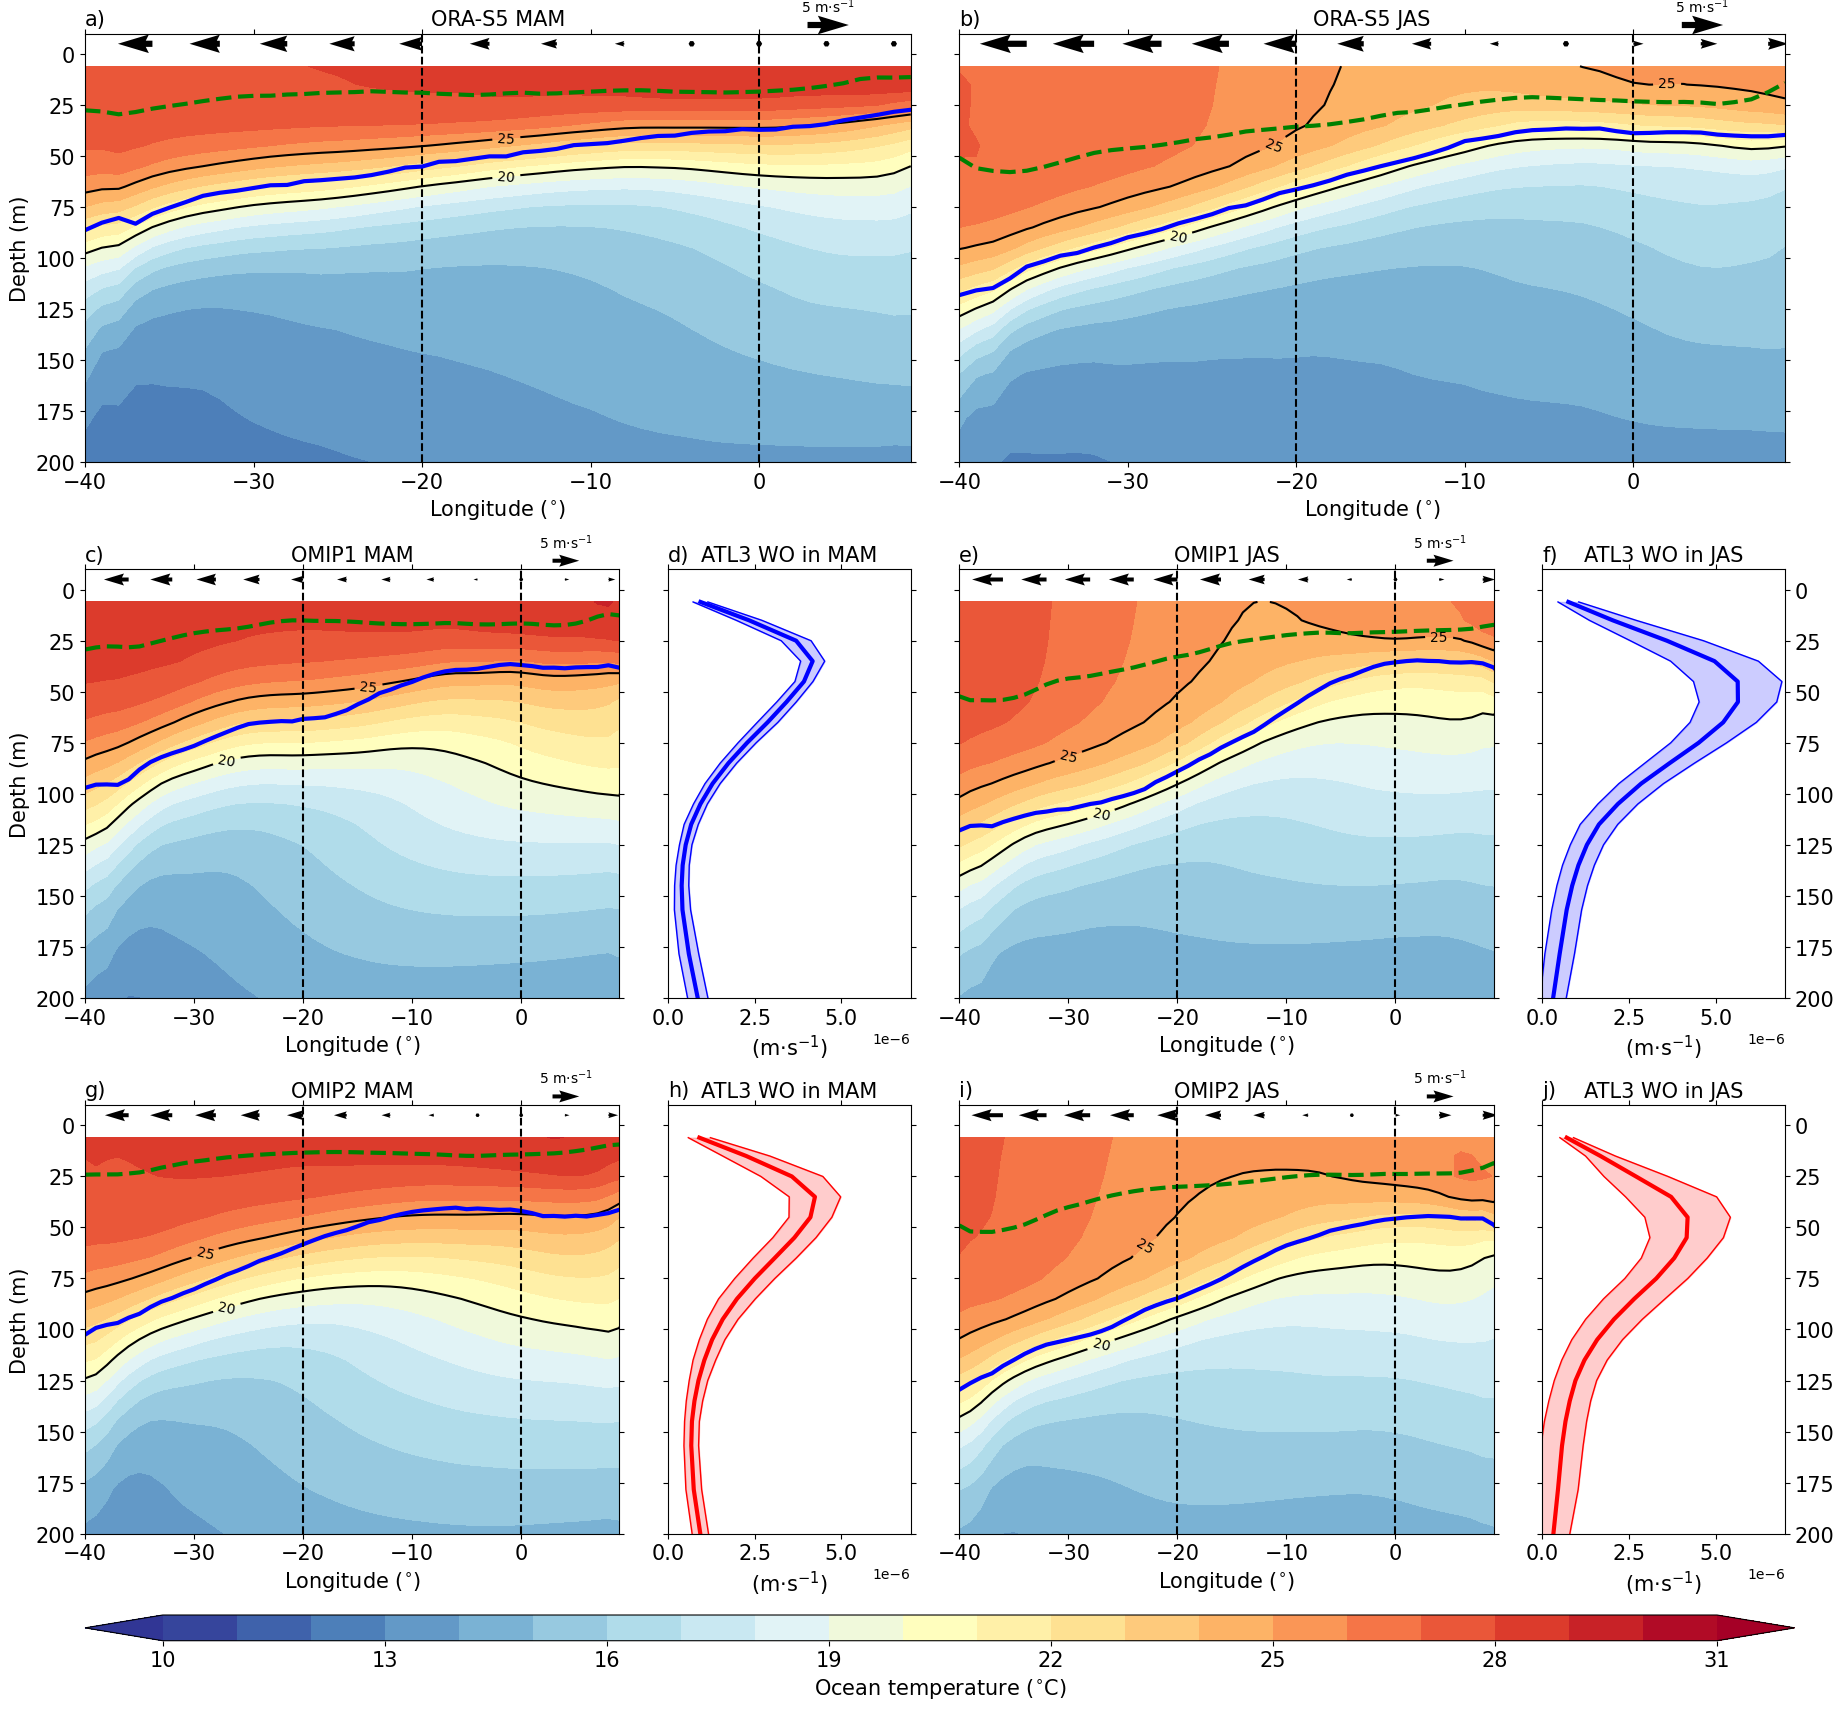

In [48]:
fig = plt.figure(figsize=[17,15])
fig.patch.set_facecolor('white')
ftz=15
gs=gridspec.GridSpec(3,6)
levels=np.arange(18,30,1)

levels_diff=np.arange(-1.4,1.6,0.2)

levels3=np.arange(10,32,1)
cmap=plt.cm.RdYlBu_r
ax0 = fig.add_subplot(gs[0,:3])

ax2 = fig.add_subplot(gs[0,3:])




ax4 = fig.add_subplot(gs[1,:2])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[1,3:5])
ax7 = fig.add_subplot(gs[1,5])



ax8 = fig.add_subplot(gs[2,:2])
ax9 = fig.add_subplot(gs[2,2])
ax10 = fig.add_subplot(gs[2,3:5])
ax11 = fig.add_subplot(gs[2,5])



cax4 = inset_axes(ax8,
                 width='320%',
                 height='6%',
                 loc='lower left',
                 bbox_to_anchor=(0,-0.25,1,1),
                 bbox_transform = ax8.transAxes,
                 borderpad=0)

plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.25, wspace=0.2)




cs0 = ax0.contour(thetao_eq_oras5_mam_mean.lon,
                  thetao_eq_oras5_mam_mean.depth,
                  thetao_eq_oras5_mam_mean.temp,colors='black',levels=[20,25])

ax0.clabel(cs0, cs0.levels, inline=True, fontsize=10)


p3 = ax0.contourf(thetao_eq_oras5_mam_mean.lon,
                  thetao_eq_oras5_mam_mean.depth,
                  thetao_eq_oras5_mam_mean.temp,cmap=cmap,levels=levels3,extend='both')


qk0 = ax0.quiver(uas_ccmp_eq_dtd_mam.lon[::4],
           np.ones(uas_ccmp_eq_dtd_mam.lon.shape[0])[::4]*(-5),
           uas_ccmp_eq_dtd_mam.uas_dtd[::4],
           np.zeros(uas_ccmp_eq_dtd_mam.lon.shape[0])[::4],scale=100)

qk = ax0.quiverkey(qk0, 0.9, 1.02, 5, r'5 m$\cdot$s$^{-1}$')
ax0.axvline(-20,color='black',linestyle='--')
ax0.axvline(0,color='black',linestyle='--')

ax0.plot(dtdz_eq_oras5_mam.lon,dtdz_eq_oras5_mam,color='blue',linewidth=3)
ax0.plot(mld_eq_oras5_mam.lon,mld_eq_oras5_mam,color='green',linewidth=3,linestyle='--')
ax0.invert_yaxis()
ax0.set_ylim([200,-10])
ax0.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=True,labelright=False,labeltop=False,labelbottom=True)

cbar = plt.colorbar(p3,cax4,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('Ocean temperature ($^{\circ}$C)',fontsize=ftz)
ax0.set_title('ORA-S5 MAM',fontsize=ftz)
ax0.set_ylabel('Depth (m)',fontsize=ftz)
ax0.set_xlabel('Longitude ($^{\circ}$)',fontsize=ftz)

ax0.set_xlim([-40,9])




cs1 = ax2.contour(thetao_eq_oras5_jas_mean.lon,
                  thetao_eq_oras5_jas_mean.depth,
                  thetao_eq_oras5_jas_mean.temp,colors='black',levels=[20,25])
ax2.clabel(cs1, cs1.levels, inline=True, fontsize=10)

p3 = ax2.contourf(thetao_eq_oras5_jas_mean.lon,
                  thetao_eq_oras5_jas_mean.depth,
                  thetao_eq_oras5_jas_mean.temp,cmap=cmap,levels=levels3,extend='both')
ax2.plot(dtdz_eq_oras5_jas.lon,dtdz_eq_oras5_jas,color='blue',linewidth=3)
ax2.plot(mld_eq_oras5_jas.lon,mld_eq_oras5_jas,color='green',linewidth=3,linestyle='--')
ax2.axvline(-20,color='black',linestyle='--')
ax2.axvline(0,color='black',linestyle='--')

ax2.invert_yaxis()
ax2.set_ylim([200,-10])
ax2.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=False,labeltop=False,labelbottom=True)
ax2.set_title('ORA-S5 JAS',fontsize=ftz)
qk1 = ax2.quiver(uas_ccmp_eq_dtd_jas.lon[::4],
           np.ones(uas_ccmp_eq_dtd_jas.lon.shape[0])[::4]*(-5),
           uas_ccmp_eq_dtd_jas.uas_dtd[::4],
           np.zeros(uas_ccmp_eq_dtd_jas.lon.shape[0])[::4],scale=100)

qk = ax2.quiverkey(qk1, 0.9, 1.02, 5, r'5 m$\cdot$s$^{-1}$')
ax2.set_xlim([-40,9])
ax2.set_xlabel('Longitude ($^{\circ}$)',fontsize=ftz)






cs2 = ax4.contour(thetao_eq_omip1_mam.lon,
                  thetao_eq_omip1_mam.depth,
                  thetao_eq_omip1_mam.mean(dim='model'),colors='black',levels=[20,25])
ax4.clabel(cs2, cs2.levels, inline=True, fontsize=10)

p3 = ax4.contourf(thetao_eq_omip1_mam.lon,
                  thetao_eq_omip1_mam.depth,
                  thetao_eq_omip1_mam.mean(dim='model'),cmap=cmap,levels=levels3,extend='both')
ax4.plot(dtdz_eq_omip1_mam.lon,dtdz_eq_omip1_mam.mean(dim='model'),color='blue',linewidth=3)
ax4.plot(mld_eq_omip1_mam.lon,mld_eq_omip1_mam.mean(dim='model'),color='green',linewidth=3,linestyle='--')
ax4.axvline(-20,color='black',linestyle='--')
ax4.axvline(0,color='black',linestyle='--')
ax4.invert_yaxis()
ax4.set_ylim([200,-10])
ax4.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=True,labelright=False,labeltop=False,labelbottom=True)
qk2 = ax4.quiver(uas_core2_eq_mam.lon[::4],
           np.ones(uas_core2_eq_mam.uas_dtd[::4].shape[0])*(-5),
           uas_core2_eq_mam.uas_dtd[::4],
           np.zeros(uas_core2_eq_mam.uas_dtd[::4].shape[0]),scale=100)
qk = ax4.quiverkey(qk2, 0.9, 1.02, 5, r'5 m$\cdot$s$^{-1}$')
ax4.set_ylabel('Depth (m)',fontsize=ftz)
ax4.set_xlim([-40,9])
ax4.set_title('OMIP1 MAM',fontsize=ftz)
ax4.set_xlabel('Longitude ($^{\circ}$)',fontsize=ftz)


ax5.plot(wo_omip1_atl3_mam.wo.mean(dim='model'),wo_omip1_atl3_mam.depth,color='blue',linewidth=3)
ax5.plot(wo_omip1_atl3_mam.wo.mean(dim='model')+
        wo_omip1_atl3_mam.wo.std(dim='model'),wo_omip1_atl3_mam.depth,color='blue',linewidth=1)
ax5.plot(wo_omip1_atl3_mam.wo.mean(dim='model')-
        wo_omip1_atl3_mam.wo.std(dim='model'),wo_omip1_atl3_mam.depth,color='blue',linewidth=1)
ax5.invert_yaxis()
ax5.set_ylim([200,-10])
ax5.set_xlim([0,7*1e-6])
ax5.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=False,labeltop=False,labelbottom=True)
ax5.set_title('ATL3 WO in MAM',fontsize=ftz)

ax5.set_xlabel( '(m$\cdot$s$^{-1}$)',fontsize=ftz)
ax5.fill_betweenx(wo_omip1_atl3_mam.depth,wo_omip1_atl3_mam.wo.mean(dim='model')-
        wo_omip1_atl3_mam.wo.std(dim='model'),wo_omip1_atl3_mam.wo.mean(dim='model')+
        wo_omip1_atl3_mam.wo.std(dim='model'),color='blue',alpha=0.2)





cs3 = ax6.contour(thetao_eq_omip1_jas.lon,
                  thetao_eq_omip1_jas.depth,
                  thetao_eq_omip1_jas.mean(dim='model'),colors='black',levels=[20,25])
ax6.clabel(cs3, cs3.levels, inline=True, fontsize=10)

p3 = ax6.contourf(thetao_eq_omip1_jas.lon,
                  thetao_eq_omip1_jas.depth,
                  thetao_eq_omip1_jas.mean(dim='model'),cmap=cmap,levels=levels3,extend='both')
ax6.plot(dtdz_eq_omip1_jas.lon,dtdz_eq_omip1_jas.mean(dim='model'),color='blue',linewidth=3)
ax6.plot(mld_eq_omip1_jas.lon,mld_eq_omip1_jas.mean(dim='model'),color='green',linewidth=3,linestyle='--')
qk3 = ax6.quiver(uas_core2_eq_jas.lon[::4],
           np.ones(uas_core2_eq_jas.uas_dtd[::4].shape[0])*(-5),
           uas_core2_eq_jas.uas_dtd[::4],
           np.zeros(uas_core2_eq_jas.uas_dtd[::4].shape[0]),scale=100)
qk = ax6.quiverkey(qk3, 0.9, 1.02, 5, r'5 m$\cdot$s$^{-1}$')
ax6.set_xlabel('Longitude ($^{\circ}$)',fontsize=ftz)
ax6.axvline(-20,color='black',linestyle='--')
ax6.axvline(0,color='black',linestyle='--')
ax6.invert_yaxis()
ax6.set_ylim([200,-10])
ax6.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=False,labeltop=False,labelbottom=True)
ax6.set_xlim([-40,9])
ax6.set_title('OMIP1 JAS',fontsize=ftz)

ax7.plot(wo_omip1_atl3_jas.wo.mean(dim='model'),wo_omip1_atl3_jas.depth,color='blue',linewidth=3)
ax7.plot(wo_omip1_atl3_jas.wo.mean(dim='model')+
        wo_omip1_atl3_jas.wo.std(dim='model'),wo_omip1_atl3_jas.depth,color='blue',linewidth=1)
ax7.plot(wo_omip1_atl3_jas.wo.mean(dim='model')-
        wo_omip1_atl3_jas.wo.std(dim='model'),wo_omip1_atl3_jas.depth,color='blue',linewidth=1)
ax7.invert_yaxis()
ax7.set_ylim([200,-10])
ax7.set_xlim([0,7*1e-6])
ax7.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=True,labeltop=False,labelbottom=True)
ax7.set_title('ATL3 WO in JAS',fontsize=ftz)

ax7.set_xlabel( '(m$\cdot$s$^{-1}$)',fontsize=ftz)

ax7.fill_betweenx(wo_omip1_atl3_jas.depth,wo_omip1_atl3_jas.wo.mean(dim='model')-
        wo_omip1_atl3_jas.wo.std(dim='model'),wo_omip1_atl3_jas.wo.mean(dim='model')+
        wo_omip1_atl3_jas.wo.std(dim='model'),color='blue',alpha=0.2)








cs4 = ax8.contour(thetao_eq_omip2_mam.lon,
                  thetao_eq_omip2_mam.depth,
                  thetao_eq_omip2_mam.mean(dim='model'),colors='black',levels=[20,25])

ax4.clabel(cs4, cs4.levels, inline=True, fontsize=10)


p3 = ax8.contourf(thetao_eq_omip2_mam.lon,
                  thetao_eq_omip2_mam.depth,
                  thetao_eq_omip2_mam.mean(dim='model'),cmap=cmap,levels=levels3,extend='both')
ax8.plot(dtdz_eq_omip2_mam.lon,dtdz_eq_omip2_mam.mean(dim='model'),color='blue',linewidth=3)
ax8.plot(mld_eq_omip2_mam.lon,mld_eq_omip2_mam.mean(dim='model'),color='green',linewidth=3,linestyle='--')
ax8.axvline(-20,color='black',linestyle='--')
ax8.axvline(0,color='black',linestyle='--')
ax8.invert_yaxis()
ax8.set_ylim([200,-10])
ax8.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=True,labelright=False,labeltop=False,labelbottom=True)
ax8.set_xlabel('Longitude ($^{\circ}$)',fontsize=ftz)
qk4 = ax8.quiver(uas_jra55_eq_mam.lon[::4],
           np.ones(uas_jra55_eq_mam.uas_dtd[::4].shape[0])*(-5),
           uas_jra55_eq_mam.uas_dtd[::4],
           np.zeros(uas_jra55_eq_mam.uas_dtd[::4].shape[0]),scale=100,linewidths=1)
qk = ax8.quiverkey(qk4, 0.9, 1.02, 5, r'5 m$\cdot$s$^{-1}$')
ax8.set_xlim([-40,9])
ax8.set_title('OMIP2 MAM',fontsize=ftz)
ax8.set_ylabel('Depth (m)',fontsize=ftz)



ax9.plot(wo_omip2_atl3_mam.wo.mean(dim='model'),wo_omip2_atl3_mam.depth,color='red',linewidth=3)
ax9.plot(wo_omip2_atl3_mam.wo.mean(dim='model')+
        wo_omip2_atl3_mam.wo.std(dim='model'),wo_omip2_atl3_mam.depth,color='red',linewidth=1)
ax9.plot(wo_omip2_atl3_mam.wo.mean(dim='model')-
        wo_omip2_atl3_mam.wo.std(dim='model'),wo_omip2_atl3_mam.depth,color='red',linewidth=1)
ax9.invert_yaxis()
ax9.set_ylim([200,-10])
ax9.set_xlim([0,7*1e-6])
ax9.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=False,labeltop=False,labelbottom=True)
ax9.set_title('ATL3 WO in MAM',fontsize=ftz)

ax9.set_xlabel( '(m$\cdot$s$^{-1}$)',fontsize=ftz)
ax9.fill_betweenx(wo_omip2_atl3_mam.depth,wo_omip2_atl3_mam.wo.mean(dim='model')-
        wo_omip2_atl3_mam.wo.std(dim='model'),wo_omip2_atl3_mam.wo.mean(dim='model')+
        wo_omip2_atl3_mam.wo.std(dim='model'),color='red',alpha=0.2)




cs5 = ax10.contour(thetao_eq_omip2_jas.lon,
                  thetao_eq_omip2_jas.depth,
                  thetao_eq_omip2_jas.mean(dim='model'),colors='black',levels=[20,25])
ax5.clabel(cs5, cs5.levels, inline=True, fontsize=10)

p3 = ax10.contourf(thetao_eq_omip2_jas.lon,
                  thetao_eq_omip2_jas.depth,
                  thetao_eq_omip2_jas.mean(dim='model'),cmap=cmap,levels=levels3,extend='both')
ax10.plot(dtdz_eq_omip2_jas.lon,dtdz_eq_omip2_jas.mean(dim='model'),color='blue',linewidth=3)
ax10.plot(mld_eq_omip2_jas.lon,mld_eq_omip2_jas.mean(dim='model'),color='green',linewidth=3,linestyle='--')
ax10.axvline(-20,color='black',linestyle='--')
ax10.axvline(0,color='black',linestyle='--')
ax10.invert_yaxis()
ax10.set_ylim([200,-10])
ax10.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=False,labeltop=False,labelbottom=True)
ax10.set_xlabel('Longitude ($^{\circ}$)',fontsize=ftz)

qk5 = ax10.quiver(uas_jra55_eq_jas.lon[::4],
           np.ones(uas_jra55_eq_jas.uas_dtd[::4].shape[0])*(-5),
           uas_jra55_eq_jas.uas_dtd[::4],
           np.zeros(uas_jra55_eq_jas.uas_dtd[::4].shape[0]),scale=100)
qk = ax10.quiverkey(qk5, 0.9, 1.02, 5, r'5 m$\cdot$s$^{-1}$')
ax10.set_xlim([-40,9])
ax10.set_title('OMIP2 JAS',fontsize=ftz)



ax11.plot(wo_omip2_atl3_jas.wo.mean(dim='model'),wo_omip2_atl3_jas.depth,color='red',linewidth=3)
ax11.plot(wo_omip2_atl3_jas.wo.mean(dim='model')+
        wo_omip2_atl3_jas.wo.std(dim='model'),wo_omip2_atl3_jas.depth,color='red',linewidth=1)
ax11.plot(wo_omip2_atl3_jas.wo.mean(dim='model')-
        wo_omip2_atl3_jas.wo.std(dim='model'),wo_omip2_atl3_jas.depth,color='red',linewidth=1)
ax11.invert_yaxis()
ax11.set_ylim([200,-10])
ax11.set_xlim([0,7*1e-6])
ax11.tick_params(labelsize=ftz,left=True,right=True,top=True,bottom=True,
                      labelleft=False,labelright=True,labeltop=False,labelbottom=True)
ax11.set_title('ATL3 WO in JAS',fontsize=ftz)

ax11.set_xlabel( '(m$\cdot$s$^{-1}$)',fontsize=ftz)
ax11.fill_betweenx(wo_omip2_atl3_jas.depth,wo_omip2_atl3_jas.wo.mean(dim='model')-
        wo_omip2_atl3_jas.wo.std(dim='model'),wo_omip2_atl3_jas.wo.mean(dim='model')+
        wo_omip2_atl3_jas.wo.std(dim='model'),color='red',alpha=0.2)



ax0.text(0,1.02,'a)',transform=ax0.transAxes,size=ftz)
ax2.text(0,1.02,'b)',transform=ax2.transAxes,size=ftz)
ax4.text(0,1.02,'c)',transform=ax4.transAxes,size=ftz)
ax5.text(0,1.02,'d)',transform=ax5.transAxes,size=ftz)
ax6.text(0,1.02,'e)',transform=ax6.transAxes,size=ftz)
ax7.text(0,1.02,'f)',transform=ax7.transAxes,size=ftz)
ax8.text(0,1.02,'g)',transform=ax8.transAxes,size=ftz)
ax9.text(0,1.02,'h)',transform=ax9.transAxes,size=ftz)
ax10.text(0,1.02,'i)',transform=ax10.transAxes,size=ftz)
ax11.text(0,1.02,'j)',transform=ax11.transAxes,size=ftz)



plt.savefig(path_fig+'figure_04.png',bbox_inches='tight',dpi=300)

In [49]:
print('OMIP1')
print('MAM')
print('depth max =',wo_omip1_atl3_mam.depth[np.argmax(wo_omip1_atl3_mam.wo.mean(dim='model').values)].values)
print('wo max = ',
      wo_omip1_atl3_mam.wo.mean(dim='model')[
          np.argmax(wo_omip1_atl3_mam.wo.mean(dim='model').values)].values,'+/-',
      wo_omip1_atl3_mam.wo.std(dim='model')[
          np.argmax(wo_omip1_atl3_mam.wo.mean(dim='model').values)].values)
print('JAS')
print('depth max =',wo_omip1_atl3_jas.depth[np.argmax(wo_omip1_atl3_jas.wo.mean(dim='model').values)].values)
print('wo max = ',
      wo_omip1_atl3_jas.wo.mean(dim='model')[
          np.argmax(wo_omip1_atl3_jas.wo.mean(dim='model').values)].values,'+/-',
      wo_omip1_atl3_jas.wo.std(dim='model')[
          np.argmax(wo_omip1_atl3_jas.wo.mean(dim='model').values)].values)

print('OMIP2')
print('MAM')
print('depth max =',wo_omip2_atl3_mam.depth[np.argmax(wo_omip2_atl3_mam.wo.mean(dim='model').values)].values)
print('wo max = ',
      wo_omip2_atl3_mam.wo.mean(dim='model')[
          np.argmax(wo_omip2_atl3_mam.wo.mean(dim='model').values)].values,'+/-',
      wo_omip2_atl3_mam.wo.std(dim='model')[
          np.argmax(wo_omip2_atl3_mam.wo.mean(dim='model').values)].values)
print('JAS')
print('depth max =',wo_omip2_atl3_jas.depth[np.argmax(wo_omip2_atl3_jas.wo.mean(dim='model').values)].values)
print('wo max = ',
      wo_omip2_atl3_jas.wo.mean(dim='model')[
          np.argmax(wo_omip2_atl3_jas.wo.mean(dim='model').values)].values,'+/-',
      wo_omip2_atl3_jas.wo.std(dim='model')[
          np.argmax(wo_omip2_atl3_jas.wo.mean(dim='model').values)].values)

OMIP1
MAM
depth max = 35.0
wo max =  4.172954290944206e-06 +/- 3.467865800148531e-07
JAS
depth max = 55.0
wo max =  5.643047649360687e-06 +/- 1.1183303833613698e-06
OMIP2
MAM
depth max = 35.0
wo max =  4.238477084288692e-06 +/- 7.411196265971556e-07
JAS
depth max = 45.0
wo max =  4.191751319803543e-06 +/- 1.232656859890427e-06


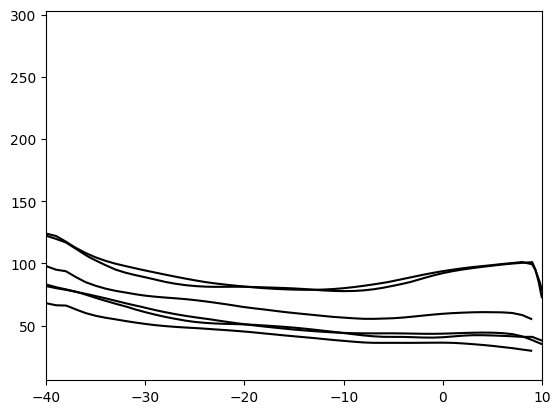

In [50]:
cs0 = plt.contour(thetao_eq_oras5_mam_mean.lon,
                  thetao_eq_oras5_mam_mean.depth,
                  thetao_eq_oras5_mam_mean.temp,colors='black',levels=[20,25])

X20, Y20 = cs0.collections[0].get_paths()[0].vertices.T
X25, Y25 = cs0.collections[1].get_paths()[0].vertices.T



cs2 = plt.contour(thetao_eq_omip1_mam.lon,
                  thetao_eq_omip1_mam.depth,
                  thetao_eq_omip1_mam.mean(dim='model'),colors='black',levels=[20,25])

X20_omip1, Y20_omip1 = cs2.collections[0].get_paths()[0].vertices.T
X25_omip1, Y25_omip1 = cs2.collections[1].get_paths()[0].vertices.T


cs3 = plt.contour(thetao_eq_omip2_mam.lon,
                  thetao_eq_omip2_mam.depth,
                  thetao_eq_omip2_mam.mean(dim='model'),colors='black',levels=[20,25])

X20_omip2, Y20_omip2 = cs3.collections[0].get_paths()[0].vertices.T
X25_omip2, Y25_omip2 = cs3.collections[1].get_paths()[0].vertices.T

In [51]:
print('ORA-S5 distance between 20degC and 25degC istoherms = ',
      np.round(np.mean(Y20[10:30]) - np.mean(Y25[10:30]),2),'m')

print('OMIP1 distance between 20degC and 25degC istoherms = ',
      np.round(np.mean(Y20_omip1[10:30]) - np.mean(Y25_omip1[10:30]),2),'m')

print('OMIP2 distance between 20degC and 25degC istoherms = ',
      np.round(np.mean(Y20_omip2[10:30]) - np.mean(Y25_omip2[10:30]),2),'m')



ORA-S5 distance between 20degC and 25degC istoherms =  19.68 m
OMIP1 distance between 20degC and 25degC istoherms =  40.61 m
OMIP2 distance between 20degC and 25degC istoherms =  41.13 m
